In [16]:
%pip install pandas
%pip install numpy
%pip install requests
%pip install beautifulsoup4
%pip install tensorflow
%pip install matplotlib
import requests
import pandas
import numpy
import requests
from bs4 import BeautifulSoup
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.
/Users/aminnazemzadeh/.zshenv:.:1: no such file or directory: /Users/aminnazemzadeh/.cargo/env
Note: you may need to restart the kernel to use updated packages.


In [17]:
path_to_training_directories = './archive/train'
path_to_test_images = './archive/test'
batch_size = 32
img_height = 32
img_width = 32

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_training_directories,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  path_to_test_images,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = train_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


2023-04-16 20:16:44.252457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-04-16 20:16:44.252874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]


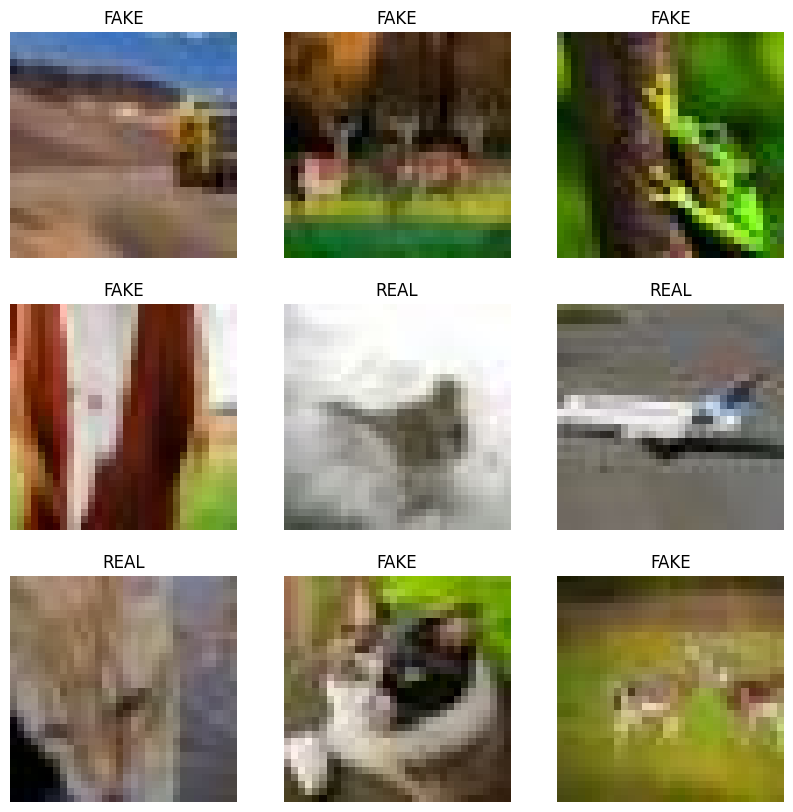

In [18]:
# lets test tensorflow tutorial first
# these are the first 9 images from training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
# these are here to boost performance
# .cache keeps the images in memory after they're loaded off disk during the first epoch
# prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
# RGB values are in the range of 0-255, we'll make it into range of 0-1
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

2023-04-16 20:16:45.284382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-04-16 20:16:45.285112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-04-16 20:16:50.870432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input p

In [21]:
# now we create the model
# we have 3 convolution blocks, activation function in relu
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)         

In [22]:
epochs=3 # change to 10 or a big number for grapghs to work
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3


2023-04-16 20:16:51.167573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]
2023-04-16 20:16:51.168364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100000]
	 [[{{node Placeholder/_4}}]]


3124/3125 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8794

2023-04-16 20:18:17.978836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20000]
	 [[{{node Placeholder/_0}}]]
2023-04-16 20:18:17.979300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20000]
	 [[{{node Placeholder/_4}}]]


3125/3125 [==============================] - 95s 29ms/step - loss: 0.2814 - accuracy: 0.8794 - val_loss: 0.2349 - val_accuracy: 0.9064
Epoch 2/3
3125/3125 [==============================] - 70s 22ms/step - loss: 0.1910 - accuracy: 0.9242 - val_loss: 0.2072 - val_accuracy: 0.9186
Epoch 3/3
3125/3125 [==============================] - 70s 23ms/step - loss: 0.1659 - accuracy: 0.9341 - val_loss: 0.1666 - val_accuracy: 0.9358


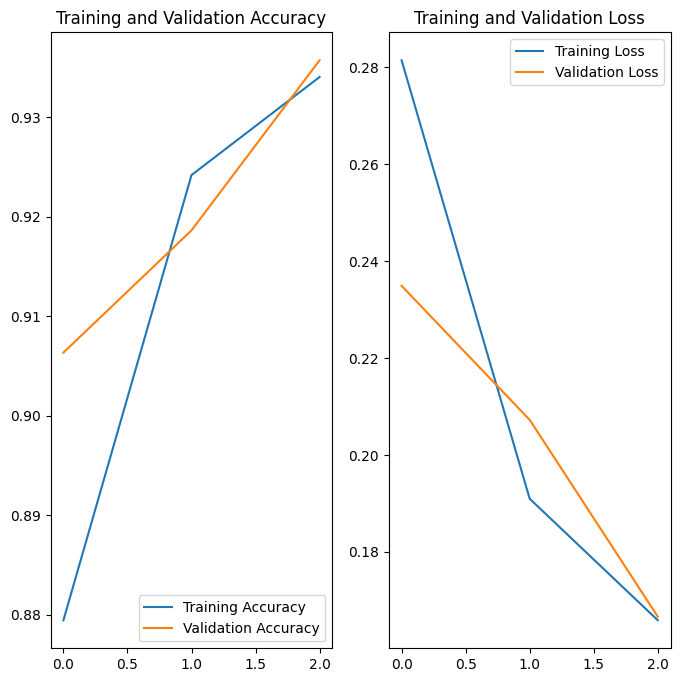

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# we see overfitting

In [ ]:
# as we saw, at the beginning, the validation has a higher accuracy than training
# we can try different number of epocs, different activation function, number of convolution networks
# and other methods to see which one works best